In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
#from sklearn.decomposition import PCA
from yellowbrick.features import PCA
import gc
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [31]:
data = pd.read_csv("sample.csv")
data_Y = data[' Label']#.to_numpy().flatten()
data_X = data.drop(columns=['Unnamed: 0', 'Flow ID', ' Timestamp', ' Label'])
del data
gc.collect()

1277

In [33]:
data_Y.value_counts()

UDPLag     100000
SNMP       100000
LDAP       100000
Syn        100000
Portmap    100000
NTP        100000
BENIGN     100000
SSDP       100000
UDP        100000
NetBIOS    100000
TFTP       100000
MSSQL      100000
DNS        100000
WebDDoS       439
Name:  Label, dtype: int64

### Feature Engineering

In [3]:
src_ip = [int(''.join([bin(int(x)+256)[3:] for x in ip.split('.')]),2) for ip in data_X[' Source IP']]
data_X[' Source IP'] = pd.Series(src_ip)

In [4]:
dst_ip = [int(''.join([bin(int(x)+256)[3:] for x in ip.split('.')]),2) for ip in data_X[' Destination IP']]
data_X[' Destination IP'] = pd.Series(dst_ip)

In [5]:
# do data_X['SimillarHTTP'].value_counts()
data_X['SimillarHTTP'][data_X['SimillarHTTP'] != 0] = 1      

In [6]:
# todo: scale before preprocessing
data_X['Flow Bytes/s'][np.isinf(data_X['Flow Bytes/s'])] = 9999999999
data_X['Flow Bytes/s'][data_X['Flow Bytes/s'].isna()] = data_X['Flow Bytes/s'].mean()

In [7]:
data_X[' Flow Packets/s'][np.isinf(data_X[' Flow Packets/s'])] = 5000000

### PCA

In [8]:
data_Y_num = data_Y.replace({'BENIGN':0, 'DNS':1, 'LDAP':2, 'MSSQL':3, 'NTP':4, 'NetBIOS':5, 'Portmap':6, 'SNMP':7,
               'SSDP':8, 'Syn':9, 'TFTP':10, 'UDP':11, 'UDPLag':12, 'WebDDoS':13}).to_numpy().flatten()

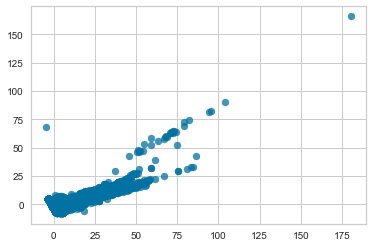

In [9]:
pca = PCA(n_components=2)
data_X_pca = pca.fit_transform(data_X)

In [10]:
data_X_pca[:5]

array([[-2.77630008,  4.50386267],
       [-1.98040137,  2.20505423],
       [-2.69884248,  4.47686262],
       [-2.52565847,  4.27083448],
       [-2.76824574,  4.50181562]])

## Train Test Split

In [11]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y, test_size=0.2, random_state=1)

In [12]:
train_Y_num = train_Y.replace({'BENIGN':0, 'DNS':1, 'LDAP':2, 'MSSQL':3, 'NTP':4, 'NetBIOS':5, 'Portmap':6, 'SNMP':7,
               'SSDP':8, 'Syn':9, 'TFTP':10, 'UDP':11, 'UDPLag':12, 'WebDDoS':13}).to_numpy().flatten()

In [13]:
test_Y_num = test_Y.replace({'BENIGN':0, 'DNS':1, 'LDAP':2, 'MSSQL':3, 'NTP':4, 'NetBIOS':5, 'Portmap':6, 'SNMP':7,
               'SSDP':8, 'Syn':9, 'TFTP':10, 'UDP':11, 'UDPLag':12, 'WebDDoS':13}).to_numpy().flatten()

## Standardizer

In [14]:
scaler = StandardScaler().fit(train_X)
train_X_std = scaler.transform(train_X)
test_X_std = scaler.transform(test_X)

## Feature Importance - Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier(random_state=0)
model = randomforest.fit(train_X_std, train_Y)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

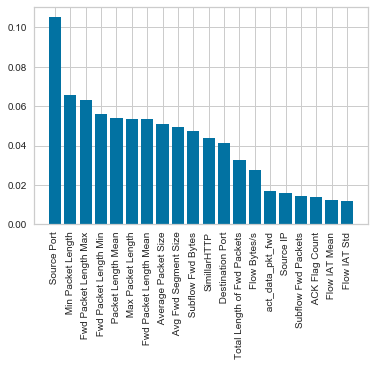

In [16]:
names = [data_X.columns[i] for i in indices]
plt.figure()
plt.bar(range(20), importances[indices][:20])
plt.xticks(range(20), names[:20], rotation=90)
plt.show()

In [17]:
randomforest.score(train_X_std, train_Y)

0.8574298481954647

In [18]:
randomforest.score(test_X_std, test_Y)

0.7927163114022946

## Training

### Logistic Regression

In [19]:
clf = LogisticRegression(random_state=0).fit(train_X_std, train_Y)
clf.score(train_X_std, train_Y)

0.6853619595694146

In [20]:
clf.score(test_X_std, test_Y)

0.6859370674540924

### NN

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, AveragePooling2D

In [22]:
train_X.shape

(1040351, 84)

In [25]:
nn = Sequential()
nn.add(Dense(128, activation='relu', input_shape=(84,)))
nn.add(Dropout(0.2))
nn.add(Dense(128, activation='relu'))
nn.add(Dropout(0.2))
nn.add(Dense(14, activation='softmax'))
nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
nn.fit(x=train_X_std, y=train_Y_num, epochs=10)

Train on 1040351 samples
Epoch 1/10
1040351/1040351 [==============================] - 184s 176us/sample - loss: 0.6257 - accuracy: 0.7046
Epoch 2/10
1040351/1040351 [==============================] - 182s 175us/sample - loss: 0.5687 - accuracy: 0.7309
Epoch 3/10
1040351/1040351 [==============================] - 182s 175us/sample - loss: 0.5532 - accuracy: 0.7439
Epoch 4/10
1040351/1040351 [==============================] - 184s 176us/sample - loss: 0.5467 - accuracy: 0.7468
Epoch 5/10
1040351/1040351 [==============================] - 179s 172us/sample - loss: 0.5480 - accuracy: 0.7447
Epoch 6/10
1040351/1040351 [==============================] - 177s 170us/sample - loss: 0.5481 - accuracy: 0.7447
Epoch 7/10
1040351/1040351 [==============================] - 180s 173us/sample - loss: 0.5473 - accuracy: 0.7466
Epoch 8/10
1040351/1040351 [==============================] - 176s 170us/sample - loss: 0.5491 - accuracy: 0.7448
Epoch 9/10
1040351/1040351 [==============================] - 1

In [28]:
nn.evaluate(test_X_std, test_Y_num)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.5131534734674221, 0.7598236]